# Backtes the three PTS Methods

In [1]:
from Methods.DmHelpers import *
from Methods.CointHelpers import *
from Methods.CopulasHelpers import *

from Helpers.DataHelpers import *
from Helpers.PlotHelpers import *
from Helpers.ModuleHelpers import *
from Helpers.BacktestHelpers import *

In [54]:
# Donwnload data
tickers = pd.read_excel('Data/SandP500list.xlsx')
tickers = tickers[tickers['sector'] == 'Financials']
names = tickers['symbol'].tolist()

START_DATE = pd.to_datetime('2020-01-01') # Every year takes approximately 30 seconds for coint and dm
END_DATE = pd.to_datetime('2024-04-01') # test 6 months yyy

data = download_data(names, START_DATE, END_DATE)

[*********************100%***********************]  65 of 65 completed


6 Failed downloads:
['PBCT', 'RE', 'WLTW', 'FRC', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SIVB']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [55]:
import pandas as pd

# Assuming END_DATE, START_DATE, train_test_dates, train_test_split, dm_get_signals_backtest, coint_get_signals_backtest, copula_get_signals_backtest, and print_backtest_info are properly defined

num_testing_periods = pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)
start_date, end_date = START_DATE, START_DATE + pd.DateOffset(months=18)

dm_backtest_results = pd.DataFrame()
coint_backtest_results = pd.DataFrame()
copula_backtest_results = pd.DataFrame()

counter = 0

while end_date < END_DATE:
    # Split data into training and testing
    train_start, train_end, test_start, test_end = train_test_dates(start_date)
    train_data, test_data = train_test_split(data, train_start, train_end, test_start, test_end)
    
    print(f"Training from {train_start} to {train_end} and testing from {test_start} to {test_end}")
    # Run backtests for each strategy
    dm_signals, dm_pairs = dm_get_signals_backtest(train_data, test_data, threshold=1.5)
    dm_signals_test = dm_signals.loc[test_start:test_end]
    coint_signals, coint_pairs = coint_get_signals_backtest(train_data, test_data, threshold=1)
    coint_signals_test = coint_signals.loc[test_start:test_end]
    copula_signals, copula_pairs = copula_get_signals_backtest(train_data, test_data) #! Threshold
    copula_signals_test = copula_signals.loc[test_start:test_end]

    # Helper function to process each set of signals
    def process_signals(signals, results_df, label):
        tuples = [(label, col) for col in signals.columns]
        multi_index = pd.MultiIndex.from_tuples(tuples, names=['Period', 'Signal'])
        period_signals = pd.DataFrame(signals.values, index=signals.index, columns=multi_index)
        return pd.concat([results_df, period_signals], axis=1)

    # Format the period label for the big column
    period_label = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"

    # Process each method's signals and update the respective DataFrame
    dm_backtest_results = process_signals(dm_signals_test, dm_backtest_results, period_label)
    coint_backtest_results = process_signals(coint_signals_test, coint_backtest_results, period_label)
    copula_backtest_results = process_signals(copula_signals_test, copula_backtest_results, period_label)

    # Update for next period
    print_backtest_info(counter, start_date, end_date)
    start_date, end_date = update_dates(start_date)
    counter += 1


Training from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 and testing from 2021-01-01 00:00:00 to 2021-07-01 00:00:00
Backtest Period: 1
Start Date: 2020-01-01 End Date: 2021-07-01
-------------------------------------------
Training from 2020-02-01 00:00:00 to 2021-02-01 00:00:00 and testing from 2021-02-01 00:00:00 to 2021-08-01 00:00:00
Backtest Period: 2
Start Date: 2020-02-01 End Date: 2021-08-01
-------------------------------------------
Training from 2020-03-01 00:00:00 to 2021-03-01 00:00:00 and testing from 2021-03-01 00:00:00 to 2021-09-01 00:00:00
Backtest Period: 3
Start Date: 2020-03-01 End Date: 2021-09-01
-------------------------------------------
Training from 2020-04-01 00:00:00 to 2021-04-01 00:00:00 and testing from 2021-04-01 00:00:00 to 2021-10-01 00:00:00
Backtest Period: 4
Start Date: 2020-04-01 End Date: 2021-10-01
-------------------------------------------
Training from 2020-05-01 00:00:00 to 2021-05-01 00:00:00 and testing from 2021-05-01 00:00:00 to 2021-11

In [81]:
import pandas as pd

def get_daily_returns_backtest(backtesting_results: pd.DataFrame, data: pd.DataFrame) -> pd.DataFrame:
    # Calculate daily returns for the price data
    data_daily_returns = data.pct_change()

    # Retrieve the unique periods from the backtesting results
    period_labels = backtesting_results.columns.levels[0]
    returns_list = []

    for period in period_labels:
        # Loop through each column within the period and calculate the daily returns
        for column in backtesting_results[period].columns:
            if 'positions' in column:
                # Extract the stock symbol from the column name
                position_type = column.split('_')[1]
                stock = column.split('_')[0] if 'positions1' in column else column.split('_')[1]
                
                # Ensure that the stock is in the data_daily_returns to avoid KeyError
                if stock in data_daily_returns.columns:
                    # Calculate daily returns by multiplying the daily returns with the shifted positions
                    # Shift positions to align with trading execution on the next day
                    daily_returns = data_daily_returns[stock] * backtesting_results[period][column].shift(1)
                    daily_returns.name = f'{stock}_{period}_{position_type}'
                    returns_list.append(daily_returns)

    # Combine all Series into one DataFrame using concat to avoid high fragmentation
    if returns_list:
        backtest_daily_returns = pd.concat(returns_list, axis=1)
    else:
        backtest_daily_returns = pd.DataFrame()

    return backtest_daily_returns

# Usage of the function
backtest_daily_returns = get_daily_returns_backtest(coint_backtest_results, data)
#print(backtest_daily_returns)
print(backtest_daily_returns)


            BK_2020-01-01 to 2021-07-01_NTRS  \
Date                                           
2020-01-02                               NaN   
2020-01-03                               NaN   
2020-01-06                               NaN   
2020-01-07                               NaN   
2020-01-08                               NaN   
...                                      ...   
2024-03-22                               NaN   
2024-03-25                               NaN   
2024-03-26                               NaN   
2024-03-27                               NaN   
2024-03-28                               NaN   

            NTRS_2020-01-01 to 2021-07-01_NTRS  \
Date                                             
2020-01-02                                 NaN   
2020-01-03                                 NaN   
2020-01-06                                 NaN   
2020-01-07                                 NaN   
2020-01-08                                 NaN   
...                      

In [74]:
import pandas as pd

def average_daily_returns(backtest_daily_returns: pd.DataFrame) -> pd.Series:
    """
    Calculate the average daily returns across all assets for each date, ignoring NaN values.

    Args:
        backtest_daily_returns (pd.DataFrame): DataFrame containing daily returns for multiple assets.

    Returns:
        pd.Series: A series containing the average daily returns for each date.
    """
    # Calculate the mean of returns across columns for each row, ignoring NaN values
    average_returns = backtest_daily_returns.mean(axis=1, skipna=True)

    return average_returns

# Example usage
# Assuming backtest_daily_returns is already defined and populated
average_returns = average_daily_returns(backtest_daily_returns)
#print(average_returns)

# plot the average daily returns
import matplotlib.pyplot as plt

def plot_average_daily_returns(average_returns: pd.Series):
    """
    Plot the average daily returns over time.

    Args:
        average_returns (pd.Series): Series containing the average daily returns for each date.
    """
    plt.figure(figsize=(14, 7))
    average_returns.plot()
    plt.title('Average Daily Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Daily Returns')
    plt.grid(True)
    plt.show()

# Example usage
#plot_average_daily_returns(average_returns)


In [73]:
import pandas as pd

def calculate_cumulative_return(average_returns: pd.Series) -> pd.Series:
    """
    Calculate the cumulative return of the portfolio from average daily returns.

    Args:
        average_returns (pd.Series): A series containing the average daily returns for each date.

    Returns:
        pd.Series: A series containing the cumulative return for each date.
    """
    # Calculate cumulative product of (1 + average_returns) to get cumulative returns
    cumulative_returns = (1 + average_returns).cumprod()

    return cumulative_returns

# Example usage
# Assuming average_returns is already defined and populated
cumulative_returns = calculate_cumulative_return(average_returns)
#print(cumulative_returns)
#plot_average_daily_returns(cumulative_returns)


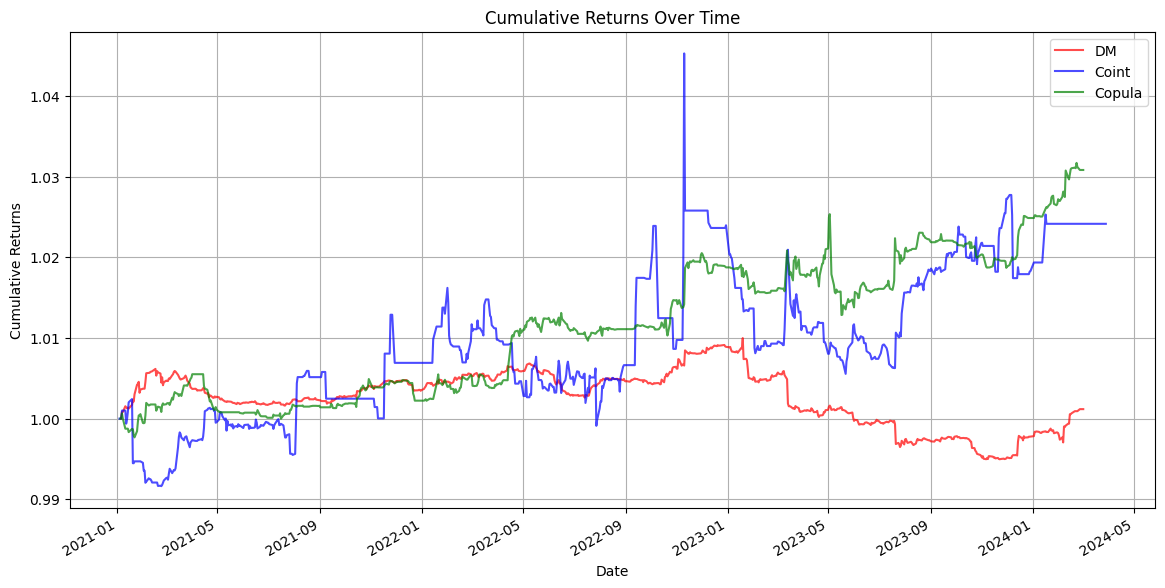

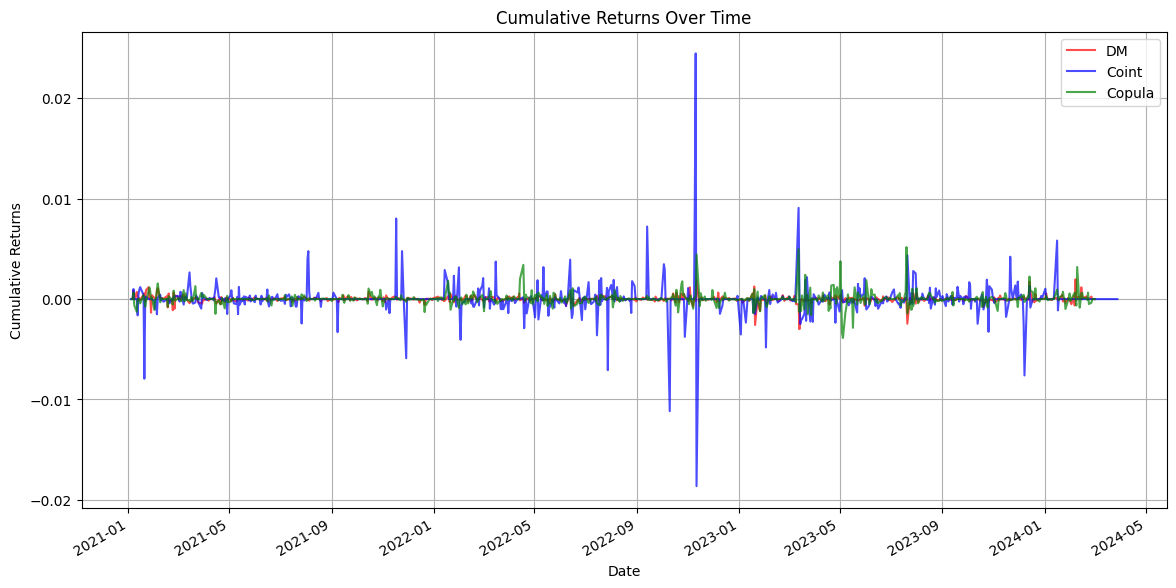

In [80]:
# get cumulative returns for each method
dm_average_returns = average_daily_returns(get_daily_returns_backtest(dm_backtest_results, data))
coint_average_returns = average_daily_returns(get_daily_returns_backtest(coint_backtest_results, data)).fillna(0)
coint_average_returns = coint_average_returns.loc[pd.to_datetime('2021-01-01'):]
copula_average_returns = average_daily_returns(get_daily_returns_backtest(copula_backtest_results, data))

dm_cum_ret = calculate_cumulative_return(dm_average_returns)
coint_cum_ret = calculate_cumulative_return(coint_average_returns)
copula_cum_ret = calculate_cumulative_return(copula_average_returns)

def plot_all_cum_retunrs(dm_cum_ret, coint_cum_ret, copula_cum_ret):
    plt.figure(figsize=(14, 7))
    dm_cum_ret.plot(label='DM', color='red', alpha=0.7)
    coint_cum_ret.plot(label='Coint', color='blue', alpha=0.7)
    copula_cum_ret.plot(label='Copula', color='green', alpha=0.7)
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_all_cum_retunrs(dm_cum_ret, coint_cum_ret, copula_cum_ret)
plot_all_cum_retunrs(dm_average_returns, coint_average_returns, copula_average_returns)